In [5]:
#Running Tofts model for one patient using the population-based AIF and saving all optimized parameters inside the tumor 
from numpy import loadtxt
from imagedata import Series
import numpy as np
import matplotlib.pyplot as plt
import os 

#Functions 
from tofts_method import *
from alignSeries_mod import *
#from mcflirt import *
from readdata import *

# load aif array
aif = loadtxt('H:/data/master endometrial data/Pop_AIF/aif_data3.csv', delimiter=',')

model_option = 'voxelwise'
read_option = 'mask2dce'

# Load patient data
patient_path = 'H:/data/master endometrial data/255/'
dce_path = os.path.join(patient_path, 'dce')
mask_path = os.path.join(patient_path, 'mask')

#Read data 
MASK, DCE, timeline = readdata(mask_path, dce_path, read_option)

patientID = DCE.patientID

#Find pixel and voxel size
spacing = DCE.spacing
z = spacing[0]
y = spacing[1]
x = spacing[2]
pixel_size = x*y
voxel_size = x*y*z
voxel_ml = voxel_size*0.001 #milliliter
    
cp = aif/(1-0.42) #42 percent Hematocrit

#Subtract pre-contrast signal from signal
DCE = DCE.astype('float32')
S0 = np.mean(DCE[0:5,:,:,:], axis=0)
dynim = DCE.copy()
for k in range(len(timeline)):
    dynim[k,:,:,:] = DCE[k,:,:,:] - S0
    
new_mask = MASK[10,:,:]
new_dce = np.asarray(dynim[:,10,:,:], dtype = 'float')

ktrans_map = np.copy(new_mask)
kep_map = np.copy(ktrans_map)
ve_map = np.copy(ktrans_map)
vp_map = np.copy(ktrans_map)

params = []
for y in range(new_mask.shape[0]): 
    for x in range(new_mask.shape[1]): 
        if new_mask[y,x] == 1.0:
            Cn = new_dce[:,y,x]
            try:
                opt_params, C_tofts_voxel = run_tofts(timeline, Cn, cp)
            except RuntimeError: 
                opt_params = {'Ktrans': np.nan, 
                              've':np.nan, 
                              'vp':np.nan, 
                              'kep':np.nan}
            params.append(opt_params)
            ktrans_map[y,x] = opt_params['Ktrans']*60
            kep_map[y,x] = opt_params['kep']*60
            vp_map[y,x] = opt_params['vp']
            ve_map[y,x] = opt_params['ve']

overflow encountered in exp


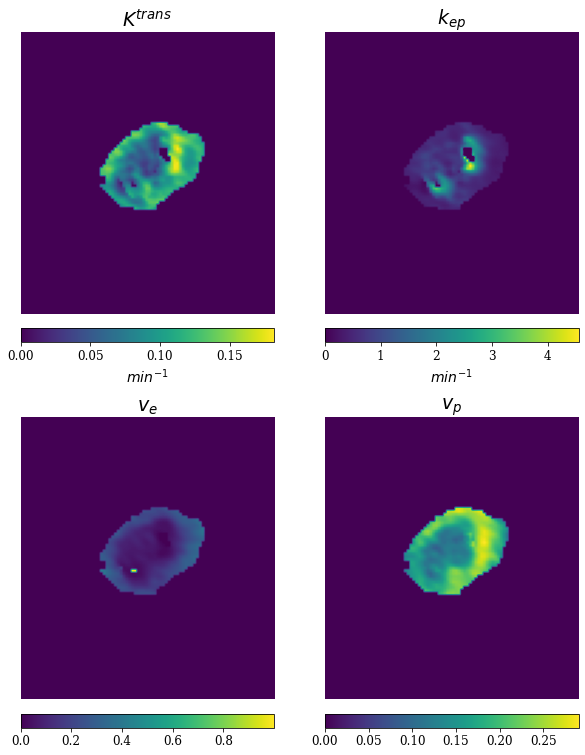

In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

#pmapfont = {'family':'serif','color':'black','size':20}

plt.subplot(2, 2, 1)
plt.rcParams.update({'font.family':'serif'})
ax = plt.gca()
im = ax.imshow(ktrans_map[80:180, 90:180], vmin=0, cmap = 'viridis')
plt.title('$K^{trans}$', size=19)
plt.axis('off')
plt.gcf().set_size_inches(10,13)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.2)
cb = plt.colorbar(im, cax=cax, orientation='horizontal')# label = '$10^{-3}$ $min^{-1}$') # Similar to fig.colorbar(im, cax = cax)
cb.set_label(label='$min^{-1}$', size=14, weight='bold')
cb.ax.tick_params(labelsize=12)
plt.gcf().set_size_inches(10,13)

plt.subplot(2,2,2)
plt.rcParams.update({'font.family':'serif'})
ax = plt.gca()
im = plt.imshow(kep_map[80:180, 90:180], vmin=0, cmap = 'viridis')
plt.title('$k_{ep}$', size=19)
plt.axis('off')
plt.gcf().set_size_inches(10,13)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.2)
cb =  plt.colorbar(im, cax=cax, orientation='horizontal') # Similar to fig.colorbar(im, cax = cax)
cb.set_label(label='$min^{-1}$', size=14, weight='bold')
cb.ax.tick_params(labelsize=12)
plt.gcf().set_size_inches(10,13)

plt.subplot(2,2,3)
plt.rcParams.update({'font.family':'serif'})
ax = plt.gca()
im = plt.imshow(ve_map[80:180, 90:180], vmin=0, cmap = 'viridis')
plt.title('$v_e$', size=19)
plt.axis('off')
plt.gcf().set_size_inches(10,13)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.2)
cb = plt.colorbar(im, cax=cax, orientation='horizontal') # Similar to fig.colorbar(im, cax = cax)
cb.ax.tick_params(labelsize=12)
plt.gcf().set_size_inches(10,13)

plt.subplot(2,2,4)
plt.rcParams.update({'font.family':'serif'})
ax = plt.gca()
im = plt.imshow(vp_map[80:180, 90:180], vmin=0, cmap = 'viridis')
plt.title('$v_p$', size=19)
plt.axis('off')
plt.gcf().set_size_inches(10,13)
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.2)
cb = plt.colorbar(im, cax=cax, orientation='horizontal') # Similar to fig.colorbar(im, cax = cax)
cb.ax.tick_params(labelsize=12)
plt.gcf().set_size_inches(10,13)
plt.savefig('H:/data/Results/ManualAIF/pmap_pdf.pdf', bbox_inches='tight')
plt.show()